In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [10]:
# Read the CSV file properly
df = pd.read_csv('bitcoin_data.csv', skiprows=[0,1])

# Rename columns properly
df.columns = ['Date', 'Close', 'Volume', 'High', 'Low', 'Open']

# Convert Date column properly
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Convert columns to float
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create features for prediction
df['Returns'] = df['Close'].pct_change()
df['Volatility'] = df['Returns'].rolling(window=20).std()
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()

# Drop rows with NaN values
df = df.dropna()

print("Data Range:", df.index.min().strftime('%Y-%m-%d'), "to", 
      df.index.max().strftime('%Y-%m-%d'))
print("\nDataset shape:", df.shape)
print("\nFeatures created:", df.columns.tolist())
print("\nFirst 5 rows of processed data:")
print(df.head())

Data Range: 2020-12-13 to 2024-11-22

Dataset shape: (1440, 10)

Features created: ['Close', 'Volume', 'High', 'Low', 'Open', 'Returns', 'Volatility', 'MA5', 'MA20', 'Volume_MA5']

First 5 rows of processed data:
                   Close       Volume          High           Low  \
Date                                                                
2020-12-13  19142.382812  25450468637  19381.535156  18734.332031   
2020-12-14  19246.644531  22473997681  19305.099609  19012.708984   
2020-12-15  19417.076172  26741982541  19525.007812  19079.841797   
2020-12-16  21310.597656  44409011479  21458.908203  19298.316406   
2020-12-17  22805.162109  71378606374  23642.660156  21234.675781   

                    Open   Returns  Volatility           MA5          MA20  \
Date                                                                         
2020-12-13  18806.765625  0.018014    0.037348  18564.770313  18630.228906   
2020-12-14  19144.492188  0.005447    0.036292  18703.316016  18637.1

In [12]:
# Prepare features (X) and target (y)
X = df[['Close', 'Volume', 'High', 'Low', 'Open', 'Returns', 'Volatility', 'MA5', 'MA20', 'Volume_MA5']]
y = df['Close'].shift(-1)  # Next day's closing price

# Remove the last row since we won't have a target value for it
X = X[:-1]
y = y[:-1]

# Split the data into training and testing sets
# Use the last year (about 252 trading days) for testing
train_size = len(X) - 252
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nFeatures used:", X.columns.tolist())
print("\nTraining date range:", X_train.index[0].strftime('%Y-%m-%d'), "to", 
      X_train.index[-1].strftime('%Y-%m-%d'))
print("Testing date range:", X_test.index[0].strftime('%Y-%m-%d'), "to", 
      X_test.index[-1].strftime('%Y-%m-%d'))

Training set shape: (1187, 10)
Testing set shape: (252, 10)

Features used: ['Close', 'Volume', 'High', 'Low', 'Open', 'Returns', 'Volatility', 'MA5', 'MA20', 'Volume_MA5']

Training date range: 2020-12-13 to 2024-03-13
Testing date range: 2024-03-14 to 2024-11-20


In [ ]:
# Create and train the Ridge regression model
# We'll try a few different alpha values to find the best one
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
best_alpha = None
best_score = float('-inf')
best_model = None

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    print(f"Alpha: {alpha}, R² Score: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_alpha = alpha
        best_model = model

print(f"\nBest alpha: {best_alpha}")
print(f"Best R² Score: {best_score:.4f}")

# Make predictions using the best model
y_pred = best_model.predict(X_test_scaled)

# Calculate error metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Metrics:")
print(f"MSE: ${mse:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

# Print feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(best_model.coef_)
})
print("\nFeature Importance:")
print(feature_importance.sort_values('Importance', ascending=False))

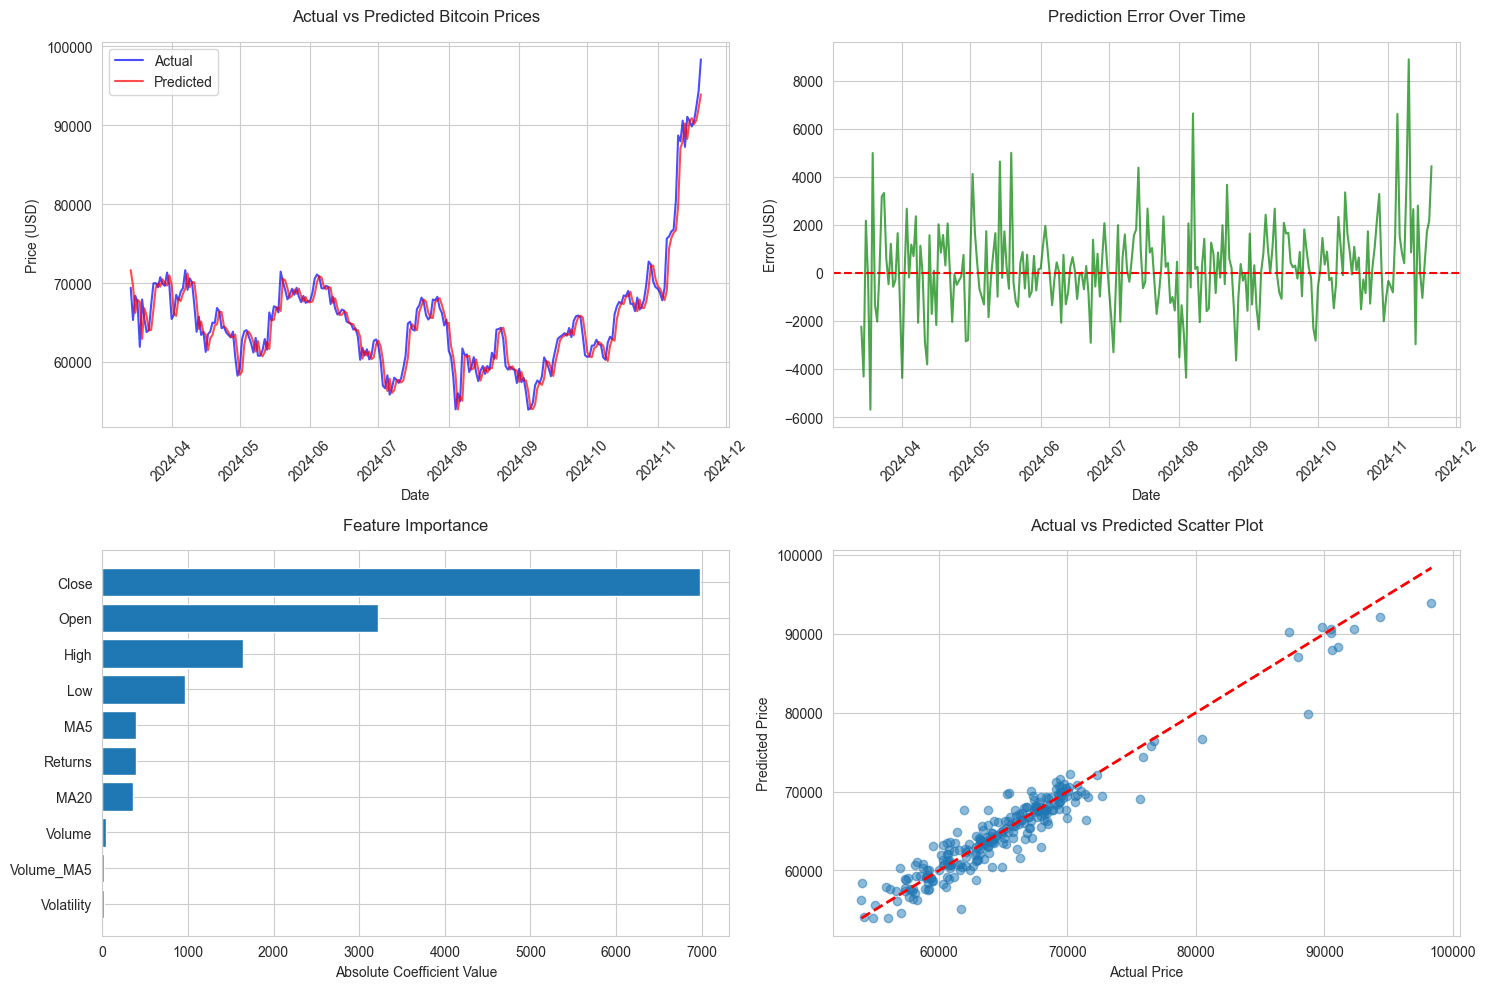


Prediction Accuracy Metrics:
Mean Absolute Percentage Error (MAPE): 2.06%
Average Daily Error: $1,349.93
Maximum Daily Error: $8,882.55
Minimum Daily Error: $9.14


In [13]:
# Set the style using seaborn
sns.set_style("whitegrid")

# Create a figure with multiple subplots
plt.figure(figsize=(15, 10))

# 1. Actual vs Predicted Prices
plt.subplot(2, 2, 1)
plt.plot(y_test.index, y_test.values, label='Actual', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted Bitcoin Prices', pad=15)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)

# 2. Prediction Error Over Time
plt.subplot(2, 2, 2)
error = y_test.values - y_pred
plt.plot(y_test.index, error, color='green', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Prediction Error Over Time', pad=15)
plt.xlabel('Date')
plt.ylabel('Error (USD)')
plt.xticks(rotation=45)

# 3. Feature Importance Plot
plt.subplot(2, 2, 3)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(best_model.coef_)
}).sort_values('Importance', ascending=True)

plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance', pad=15)
plt.xlabel('Absolute Coefficient Value')

# 4. Scatter Plot of Actual vs Predicted
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Scatter Plot', pad=15)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Additional analysis: Print prediction accuracy metrics
print("\nPrediction Accuracy Metrics:")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(np.abs(error / y_test.values)) * 100:.2f}%")
print(f"Average Daily Error: ${np.mean(np.abs(error)):,.2f}")
print(f"Maximum Daily Error: ${np.max(np.abs(error)):,.2f}")
print(f"Minimum Daily Error: ${np.min(np.abs(error)):,.2f}")